In [1]:
# # If you're on Colab or a clean environment, run this cell first.

# # Install Whisper + deps. If you already have these, you can skip.
# # Whisper needs ffmpeg on PATH. This cell tries to ensure it's available.
# # On some platforms you may need to install ffmpeg manually (see messages below).

# import shutil
# import sys
# import subprocess

# def pip_install(pkg):
#     print(f"Installing: {pkg}")
#     subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

# # Core deps
# pip_install("openai-whisper")
# pip_install("soundfile")
# pip_install("numpy")
# pip_install("pandas")
# pip_install("matplotlib")

# # Optional: try torch if not already present (Whisper will pull it, but just in case)
# try:
#     import torch  # noqa
# except Exception:
#     pip_install("torch")

# # Ensure ffmpeg exists
# ffmpeg_path = shutil.which("ffmpeg")
# if ffmpeg_path is None:
#     print("[INFO] 'ffmpeg' not found on PATH. Attempting to install system ffmpeg (Linux/Colab-only).")
#     # Best-effort: works on Debian/Ubuntu-like. Ignore errors on other OSes.
#     try:
#         subprocess.check_call(["apt-get", "update", "-y"])
#         subprocess.check_call(["apt-get", "install", "-y", "ffmpeg"])
#     except Exception as e:
#         print("[WARN] Automatic ffmpeg install failed. Please install ffmpeg manually and re-run.")
# else:
#     print(f"[OK] ffmpeg found at: {ffmpeg_path}")

# print("Setup complete.")


### Cell 1 — Imports & configuration

In [2]:
from pathlib import Path
import json
import re
from collections import Counter
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- Paths ----
METADATA_PATH = Path("metadata/train_metadata.json")

# Your audio: prefer the correct spelling; fall back to the misspelling you mentioned.
AUDIO_DIR_PRIMARY = Path("train/signals")
AUDIO_DIR_FALLBACK = Path("train/singals")

# ---- Whisper config ----
MODEL_NAME = "base"   # "tiny", "base", "small", "medium", "large"
LANGUAGE = "en"       # None to auto-detect
MAX_FILES = 50000        # change to process more/less

np.random.seed(42)

print("Config loaded.")
print("Metadata path:", METADATA_PATH)
print("Audio primary dir:", AUDIO_DIR_PRIMARY, "| fallback:", AUDIO_DIR_FALLBACK)
print("Model:", MODEL_NAME, "| Language:", LANGUAGE, "| MAX_FILES:", MAX_FILES)


Config loaded.
Metadata path: metadata\train_metadata.json
Audio primary dir: train\signals | fallback: train\singals
Model: base | Language: en | MAX_FILES: 50000


### Cell 2 — Load metadata & preview

In [3]:
def load_metadata_safe(path: Path):
    if not path.exists():
        raise FileNotFoundError(
            f"Metadata file not found: {path.resolve()}\n"
            "Please make sure the dataset is available locally with the same structure."
        )
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    # Normalize / ensure keys
    for row in data:
        row.setdefault("prompt", row.get("original_prompt", "") or "")
        row.setdefault("n_words", None)
        row.setdefault("correctness", None)
    return data

metadata = load_metadata_safe(METADATA_PATH)
df_meta = pd.DataFrame(metadata)
keep_cols = ["signal", "fma", "prompt", "n_words", "correctness", "hearing_loss"]
df_meta = df_meta[[c for c in keep_cols if c in df_meta.columns]]

print(f"Loaded {len(df_meta)} rows.")
display(df_meta.head(10))


Loaded 8802 rows.


,signal,fma,prompt,n_words,correctness,hearing_loss
0,c221f2084c780e8f212f4697,147301,cos you better hold on,5,0.000000,Moderate
1,63de05fbfcab2d7748b83cb3,000649,and then lower it down again,6,0.166667,Mild
2,cf74c013a02d82d04254a910,022968,the blind sleep and the deaf and dumb sleep,9,0.777778,No Loss
3,56f3fb4847d2c90f38e8e983,124993,a street a couple of cars and maybe some trees,10,0.000000,Moderate
4,b2486a8e181f84acd2db4d61,001750,in my mind i can see is fine,8,0.000000,Moderate
5,4119c3d170a7c478c00ef21d,081474,we slaves and we masters flesh out beast disas...,9,0.222222,Moderate
6,60aa30c1cde48138efe6d172,022481,you are sleeping with a pig,6,0.833333,Mild
7,710c8b1d9cc589b5414634bb,153769,but maybe getting far from the dark,7,1.000000,No Loss
8,09449f9926c4222b7b6d0460,131956,cheyenne cheyenne hop on the ponies,6,0.000000,No Loss
9,6cc97125bb708b1fa5a55e7e,022479,he was mauvish in the shops,6,0.166667,Mild


### Cell 3 — Text normalization & scoring utilities

In [4]:
_word_re = re.compile(r"[a-zA-Z0-9']+")

def normalize_text(text: str) -> str:
    """Lowercase, strip punctuation (keep alphanumerics and apostrophes), collapse spaces."""
    text = text.lower()
    tokens = _word_re.findall(text)
    return " ".join(tokens)

def tokenize(text: str):
    return normalize_text(text).split()

def bag_overlap_count(ref_tokens, hyp_tokens) -> int:
    """
    Count how many reference words appear in hypothesis using bag-of-words overlap.
    Each reference word can only be matched up to its frequency in the hypothesis.
    """
    ref_counter = Counter(ref_tokens)
    hyp_counter = Counter(hyp_tokens)
    return sum(min(c, hyp_counter.get(w, 0)) for w, c in ref_counter.items())

def compute_words_correct_and_rate(prompt_text: str, transcript_text: str):
    """
    Returns (words_correct, correctness_rate) where
    - words_correct = number of words in the prompt that appear in the transcript (bag match)
    - correctness_rate = words_correct / n_words_in_prompt
    """
    ref_tokens = tokenize(prompt_text)
    hyp_tokens = tokenize(transcript_text)
    n_words = len(ref_tokens)
    wc = bag_overlap_count(ref_tokens, hyp_tokens)
    rate = (wc / n_words) if n_words > 0 else 0.0
    return wc, rate

# Quick self-test
_rc, _rr = compute_words_correct_and_rate("Cos you better hold on", "you better hold on to me")
print("Self-test -> words_correct:", _rc, "rate:", round(_rr, 3))


Self-test -> words_correct: 4 rate: 0.8


### Cell 4 — Whisper setup (device + model load)

In [5]:
import shutil

try:
    import torch
    device = "cuda" if torch.cuda.is_available() else "cpu"
except Exception:
    device = "cpu"

import whisper

# Sanity check for ffmpeg
if shutil.which("ffmpeg") is None:
    print("[WARN] ffmpeg still not found on PATH. Whisper may fail to load audio. "
          "Install ffmpeg and restart kernel if you get audio errors.")

print("Device:", device)
model = whisper.load_model(MODEL_NAME, device=device)
print(f"Loaded Whisper model: {MODEL_NAME}")


Device: cpu
Loaded Whisper model: base


### Cell 5 — Helpers to find audio & transcribe

In [6]:
def find_audio_path(signal_id: str) -> Path:
    """
    Try to locate the audio file in primary then fallback directory.
    Returns None if not found.
    """
    filename = f"{signal_id}.flac"
    p1 = AUDIO_DIR_PRIMARY / filename
    if p1.exists():
        return p1
    p2 = AUDIO_DIR_FALLBACK / filename
    if p2.exists():
        return p2
    return None

def transcribe_audio(path: Path, language: str = LANGUAGE) -> str:
    """
    Run Whisper transcription on an audio file and return the text.
    """
    kwargs = {"language": language} if language else {}
    result = model.transcribe(str(path), **kwargs)
    return (result.get("text") or "").strip()

print("Helpers ready.")


Helpers ready.


### Cell 6 — Run baseline on a subset & compute scores

In [7]:
# def run_baseline(df: pd.DataFrame, max_files: int = 50) -> pd.DataFrame:
#     rows = []
#     processed = 0

#     for _, row in df.iterrows():
#         if processed >= max_files:
#             break

#         sid = str(row["signal"])
#         prompt = row.get("prompt", "") or ""
#         n_words = int(row.get("n_words") or 0)
#         meta_corr = row.get("correctness")
#         meta_corr = float(meta_corr) if meta_corr is not None else None

#         audio_path = find_audio_path(sid)
#         if audio_path is None:
#             rows.append({
#                 "signal": sid,
#                 "prompt": prompt,
#                 "n_words": n_words,
#                 "meta_correctness": meta_corr,
#                 "asr_text": None,
#                 "asr_words_correct": None,
#                 "asr_correctness": None,
#                 "abs_error": None,
#                 "note": "audio_missing",
#             })
#             continue

#         asr_text = transcribe_audio(audio_path, language=LANGUAGE)
#         wc, rate = compute_words_correct_and_rate(prompt, asr_text)
#         abs_err = (abs(rate - meta_corr) if (meta_corr is not None) else None)

#         rows.append({
#             "signal": sid,
#             "prompt": prompt,
#             "n_words": n_words,
#             "meta_correctness": meta_corr,
#             "asr_text": asr_text,
#             "asr_words_correct": wc,
#             "asr_correctness": rate,
#             "abs_error": abs_err,
#             "note": None
#         })
#         processed += 1

#     return pd.DataFrame(rows)

# df_results = run_baseline(df_meta, MAX_FILES)
# print("Results shape:", df_results.shape)
# display(df_results.head(10))


In [8]:
from tqdm.notebook import tqdm

def run_baseline(df: pd.DataFrame, max_files: int = 50) -> pd.DataFrame:
    rows = []
    processed = 0     # successfully processed items (with audio)
    missing = 0       # missing-audio items (not counted toward max_files)

    with tqdm(total=min(len(df), max_files), desc="ASR baseline (processed files)", unit="file") as pbar:
        for _, row in df.iterrows():
            if processed >= max_files:
                break

            sid = str(row["signal"])
            prompt = row.get("prompt", "") or ""
            n_words = int(row.get("n_words") or 0)
            meta_corr = row.get("correctness")
            meta_corr = float(meta_corr) if meta_corr is not None else None

            audio_path = find_audio_path(sid)
            if audio_path is None:
                rows.append({
                    "signal": sid,
                    "prompt": prompt,
                    "n_words": n_words,
                    "meta_correctness": meta_corr,
                    "asr_text": None,
                    "asr_words_correct": None,
                    "asr_correctness": None,
                    "abs_error": None,
                    "note": "audio_missing",
                })
                missing += 1
                # not updating processed or the progress bar here (truthful to logic)
                pbar.set_postfix({"done": processed, "missing": missing})
                continue

            asr_text = transcribe_audio(audio_path, language=LANGUAGE)
            wc, rate = compute_words_correct_and_rate(prompt, asr_text)
            abs_err = (abs(rate - meta_corr) if (meta_corr is not None) else None)

            rows.append({
                "signal": sid,
                "prompt": prompt,
                "n_words": n_words,
                "meta_correctness": meta_corr,
                "asr_text": asr_text,
                "asr_words_correct": wc,
                "asr_correctness": rate,
                "abs_error": abs_err,
                "note": None
            })

            processed += 1
            pbar.update(1)
            pbar.set_postfix({"done": processed, "missing": missing})

    return pd.DataFrame(rows)

df_results = run_baseline(df_meta, MAX_FILES)
print("Results shape:", df_results.shape)
display(df_results.head(10))


ASR baseline (processed files):   0%|          | 0/8802 [00:00<?, ?file/s]

D:\softwares\Anaconda\envs\4347\lib\site-packages\whisper\transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Results shape: (8802, 9)


,signal,prompt,n_words,meta_correctness,asr_text,asr_words_correct,asr_correctness,abs_error,note
0,c221f2084c780e8f212f4697,cos you better hold on,5,0.000000,Could you better hold on?,4,0.800000,8.000000e-01,None
1,63de05fbfcab2d7748b83cb3,and then lower it down again,6,0.166667,And then roll it down again.,5,0.833333,6.666667e-01,None
2,cf74c013a02d82d04254a910,the blind sleep and the deaf and dumb sleep,9,0.777778,"So fly, sleeper than death and up sleep",2,0.222222,5.555556e-01,None
3,56f3fb4847d2c90f38e8e983,a street a couple of cars and maybe some trees,10,0.000000,Always worked in a different military room...,1,0.100000,1.000000e-01,None
4,b2486a8e181f84acd2db4d61,in my mind i can see is fine,8,0.000000,REPEAT FOR ME,0,0.000000,0.000000e+00,None
5,4119c3d170a7c478c00ef21d,we slaves and we masters flesh out beast disas...,9,0.222222,"We fight them, we master, but shall be disastr...",2,0.222222,2.222220e-11,None
6,60aa30c1cde48138efe6d172,you are sleeping with a pig,6,0.833333,You're sleeping with a pig.,4,0.666667,1.666667e-01,None
7,710c8b1d9cc589b5414634bb,but maybe getting far from the dark,7,1.000000,But maybe get far from the dark,6,0.857143,1.428571e-01,None
8,09449f9926c4222b7b6d0460,cheyenne cheyenne hop on the ponies,6,0.000000,All right,0,0.000000,0.000000e+00,None
9,6cc97125bb708b1fa5a55e7e,he was mauvish in the shops,6,0.166667,He would know which in the child,3,0.500000,3.333333e-01,None


### Cell 7 — Metrics & visualization

MAE:  0.2580
RMSE: 0.3610
Pearson r: 0.5158


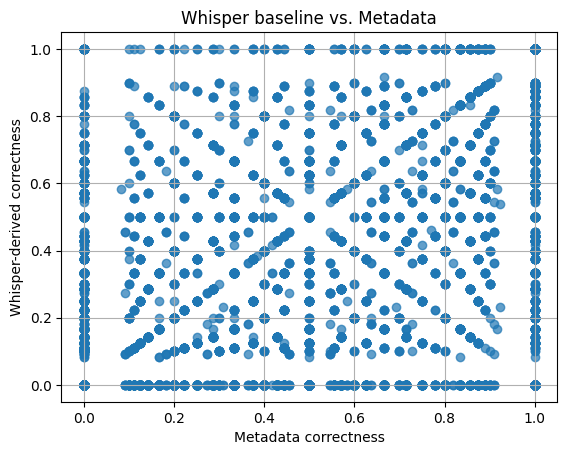

In [9]:
if df_results.empty:
    print("[INFO] No results to analyze. Check paths and MAX_FILES, then re-run.")
else:
    valid = df_results.dropna(subset=["meta_correctness", "asr_correctness"])

    if valid.empty:
        print("[INFO] No rows with both meta and ASR correctness.")
    else:
        y_true = valid["meta_correctness"].to_numpy(dtype=float)
        y_pred = valid["asr_correctness"].to_numpy(dtype=float)

        mae = np.mean(np.abs(y_pred - y_true))
        rmse = math.sqrt(np.mean((y_pred - y_true) ** 2))
        r = np.corrcoef(y_true, y_pred)[0, 1] if len(valid) > 1 else np.nan

        print(f"MAE:  {mae:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"Pearson r: {r:.4f}")

        # Scatter plot (matplotlib only; one chart; no explicit colors)
        plt.figure()
        plt.scatter(y_true, y_pred, alpha=0.7)
        plt.xlabel("Metadata correctness")
        plt.ylabel("Whisper-derived correctness")
        plt.title("Whisper baseline vs. Metadata")
        plt.grid(True)
        plt.show()


In [10]:
OUT_CSV = Path("whisper_baseline_results.csv")
df_results.to_csv(OUT_CSV, index=False, encoding="utf-8")
print(f"Saved per-file results to: {OUT_CSV.resolve()}")


Saved per-file results to: D:\resources\modules\m4sem1\cs5647\cadenza_data\whisper_baseline_results.csv


In [11]:
# Cell A — Prepare results with hearing_loss & basic cleaning
# Re-create minimal context if kernel restarted: try to load from CSV as fallback.
from pathlib import Path
import pandas as pd
import numpy as np

RESULTS_CSV = Path("whisper_baseline_results.csv")
METADATA_JSON = Path("metadata/train_metadata.json")

# Attempt to reconstruct df_results if missing by reading CSV
if 'df_results' not in globals():
    if RESULTS_CSV.exists():
        df_results = pd.read_csv(RESULTS_CSV)
        print(f"[INFO] Loaded df_results from {RESULTS_CSV}")
    else:
        df_results = pd.DataFrame()
        print("[WARN] df_results not in memory and CSV not found. Proceeding with empty frame.")

# Attempt to reconstruct df_meta if missing by reading JSON
if 'df_meta' not in globals():
    if METADATA_JSON.exists():
        import json
        with open(METADATA_JSON, "r", encoding="utf-8") as f:
            meta = json.load(f)
        df_meta = pd.DataFrame(meta)
        print(f"[INFO] Loaded df_meta from {METADATA_JSON}")
    else:
        df_meta = pd.DataFrame()
        print("[WARN] df_meta not in memory and metadata JSON not found. Proceeding with empty frame.")

# Merge hearing_loss into results if needed
if not df_results.empty and ('hearing_loss' not in df_results.columns):
    if not df_meta.empty and 'signal' in df_meta.columns and 'hearing_loss' in df_meta.columns:
        df_results = df_results.merge(
            df_meta[['signal', 'hearing_loss']].drop_duplicates(),
            on='signal', how='left'
        )
    else:
        print("[WARN] Could not merge 'hearing_loss' because df_meta is unavailable or missing columns.")

# Filter to valid hearing_loss values
valid_hl = {"No Loss", "Mild", "Moderate"}
if not df_results.empty and 'hearing_loss' in df_results.columns:
    df_results['hearing_loss'] = df_results['hearing_loss'].fillna('Unknown')
    df_results = df_results[df_results['hearing_loss'].isin(valid_hl)].copy()

# Build analysis frame
analysis_cols = ["signal", "hearing_loss", "asr_correctness", "meta_correctness", "abs_error"]
present_cols = [c for c in analysis_cols if (not df_results.empty and c in df_results.columns)]
df_analysis = df_results[present_cols].dropna(subset=["asr_correctness"]) if present_cols else pd.DataFrame()

print("Prepared analysis frame with shape:", df_analysis.shape)
df_analysis.head(10)


Prepared analysis frame with shape: (8802, 5)


,signal,hearing_loss,asr_correctness,meta_correctness,abs_error
0,c221f2084c780e8f212f4697,Moderate,0.800000,0.000000,8.000000e-01
1,63de05fbfcab2d7748b83cb3,Mild,0.833333,0.166667,6.666667e-01
2,cf74c013a02d82d04254a910,No Loss,0.222222,0.777778,5.555556e-01
3,56f3fb4847d2c90f38e8e983,Moderate,0.100000,0.000000,1.000000e-01
4,b2486a8e181f84acd2db4d61,Moderate,0.000000,0.000000,0.000000e+00
5,4119c3d170a7c478c00ef21d,Moderate,0.222222,0.222222,2.222220e-11
6,60aa30c1cde48138efe6d172,Mild,0.666667,0.833333,1.666667e-01
7,710c8b1d9cc589b5414634bb,No Loss,0.857143,1.000000,1.428571e-01
8,09449f9926c4222b7b6d0460,No Loss,0.000000,0.000000,0.000000e+00
9,6cc97125bb708b1fa5a55e7e,Mild,0.500000,0.166667,3.333333e-01


=== RMSE of Whisper correctness vs. ground truth by hearing_loss ===


C:\Users\tygq\AppData\Local\Temp\ipykernel_23364\934024421.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  groups.apply(lambda g: np.sqrt(np.mean((g["asr_correctness"] - g["meta_correctness"])**2)))


,hearing_loss,rmse
1,Moderate,0.340271
0,Mild,0.363018
2,No Loss,0.378792


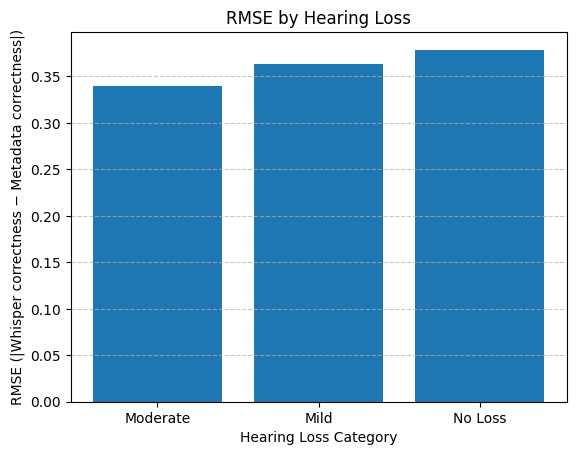


ANOVA on squared error: F=13.2358, p=1.82142e-06
Kruskal–Wallis on squared error: H=133.1116, p=1.24501e-29


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# --- 1. Compute per-group RMSE ---
if df_analysis.empty:
    print("[INFO] df_analysis is empty. Run the merge cell first.")
else:
    # Filter to rows with both correctness values
    valid = df_analysis.dropna(subset=["meta_correctness", "asr_correctness"]).copy()
    groups = valid.groupby("hearing_loss")

    rmse_summary = (
        groups.apply(lambda g: np.sqrt(np.mean((g["asr_correctness"] - g["meta_correctness"])**2)))
        .reset_index(name="rmse")
        .sort_values("rmse")
    )

    print("=== RMSE of Whisper correctness vs. ground truth by hearing_loss ===")
    display(rmse_summary)

    # --- 2. Visualization ---
    plt.figure()
    plt.bar(rmse_summary["hearing_loss"], rmse_summary["rmse"])
    plt.ylabel("RMSE (|Whisper correctness − Metadata correctness|)")
    plt.xlabel("Hearing Loss Category")
    plt.title("RMSE by Hearing Loss")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

    # --- 3. Statistical test: ANOVA/Kruskal on per-sample squared errors ---
    valid["squared_error"] = (valid["asr_correctness"] - valid["meta_correctness"])**2

    data = [valid.loc[valid["hearing_loss"] == h, "squared_error"].dropna().to_numpy()
            for h in ["No Loss", "Mild", "Moderate"]]
    data = [d for d in data if len(d) > 1]

    if len(data) >= 2:
        f, p_anova = stats.f_oneway(*data)
        h, p_kw = stats.kruskal(*data)
        print(f"\nANOVA on squared error: F={f:.4f}, p={p_anova:.6g}")
        print(f"Kruskal–Wallis on squared error: H={h:.4f}, p={p_kw:.6g}")
    else:
        print("[INFO] Not enough data for significance tests.")
